In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import skfmm

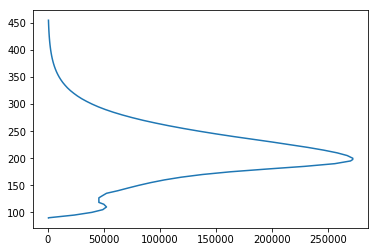

In [5]:
# Load an ionogram to get charge density as a function of height
with open('data/NHPC_Profiles-20190126120000-30611') as fi:
    hli = 0    # header line index
    rep = []
    loc_name = ''
    loc_id = ''
    date = ''
    time = ''
    
    for line in fi:
        if hli == 0:
            [loc_name, loc_id, date, time] = line.split()
            loc_id = loc_id[1:-2]
            hli = 1
            continue
            
        elif hli < 4:
            hli += 1
            continue
        
        elif line == '===\n':
            ofn = 'data/processed/' + loc_id + '_' + date + '_' + time + '.csv'
            if len(rep) > 0 and rep[0] != '\n':
                with open(ofn, 'w') as fo:
                    fo.write('Height,Frequency,Density\n')
                    for ol in rep:
                        op = ''
                        for os in ol.split():
                            op += os + ','
                        fo.write(op[0:-1] + '\n')
            hli = 0
            rep.clear()
        else:
            rep.append(line)

df = pd.read_csv('data/processed/mo155_2019-01-26_12:01:00.csv')
plt.plot(df['Density'], df['Height'])

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [0.99999999 0.99999999 0.99999999 ... 0.99999999 0.99999999 0.99999999]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


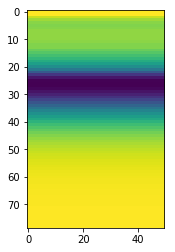

In [27]:
# Produce n(h) from the charge density

E_CHARGE = 1.60217662e-19 # coulombs
E_MASS = 9.109e-31 # kg
EPSILON_0 = 8.854187817e-12 # F m^−1


def count2omega_p(count):
    return np.sqrt(count * (E_CHARGE ** 2) / EPSILON_0 / E_MASS)


def freq2omega(freq):
    return 2 * np.pi * freq
    

def omegas2n(omega_p, omega):
    return np.sqrt(1 - (omega_p ** 2) / (omega ** 2))


# Assume for now we're TX at 10 MHz
# Calculate index of refraction
tx_freq = 10e6 # hz
index = omegas2n(count2omega_p(df['Density']), freq2omega(tx_freq))
plt.plot(index, df['Height'])

# Expand n(h) to n(x,y)
i2d = np.tile(np.array([index]).transpose(), (1, 50))
print(i2d)
plt.imshow(i2d)

# Noise n(x,y)

# Evaluate FMM

In [33]:
X, Y = np.meshgrid(np.linspace(-1,1,len(index)), np.linspace(-1,1,len(index)))
phi = (X+0.8)**2+(Y+0.8)**2 - 0.01

skfmm.travel_time(phi, i2d, dx=2.0/500, periodic=(1,0))

ValueError: phi and speed must have the same shape